# DS-SF-30 | Final Project 2: Exploratory Data Analysis

This project is to implement the exploratory analysis plan for Analysing 911 calls assigned to San Francisco Fire Department (SFFD). 

Data of Calls to SFFD has been downloaded from https://data.sfgov.org/Public-Safety/Fire-Department-Calls-for-Service/nuek-vuh3 . A subset of data from January 1, 2017 to January 7, 2017 is used for Analysis here.

In [1]:
import os

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 10)
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 10)

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn import linear_model, cross_validation, preprocessing, neighbors, grid_search

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

Read in SFFD dataset:

In [2]:
df = pd.read_csv(os.path.join('..', 'datasets', 'Fire_Department_Calls_Jan_1_7.csv'))

In [131]:
df.head()

,Call Number,Unit ID,Incident Number,Call Type,Call Date,...,Fire Prevention District,Supervisor District,Neighborhood District,Location,RowID
0,170020008,T03,17000562,Elevator / Escalator Rescue,01/01/2017,...,1,3,Tenderloin,"(37.7875044952742, -122.414163693123)",170020008-T03
1,170014120,T06,17000560,Medical Incident,01/01/2017,...,2,9,Mission,"(37.7657922226195, -122.420909958943)",170014120-T06
2,170014120,RC3,17000560,Medical Incident,01/01/2017,...,2,9,Mission,"(37.7657922226195, -122.420909958943)",170014120-RC3
3,170014120,E07,17000560,Medical Incident,01/01/2017,...,2,9,Mission,"(37.7657922226195, -122.420909958943)",170014120-E07
4,170014120,E06,17000560,Medical Incident,01/01/2017,...,2,9,Mission,"(37.7657922226195, -122.420909958943)",170014120-E06


> ### Number of observations in the dataset

In [3]:
df.shape

(6852, 34)

6852 rows and 34 columns

> ### Exploring the features in the dataset

A description of the dataset is as follows:

- Call Number: A unique 9-digit number assigned by the 911 Dispatch Center (DEM) to this call. These number are used for both Police and Fire calls.

- Unit ID 

- Incident Number: A unique 8-digit number assigned by DEM to this Fire incident.

- Call Type

- Call Date: Date the call is received at the 911 Dispatch Center.

- Watch Date: Watch date when the call is received. Watch date starts at 0800 each morning and ends at 0800 the next day.

- Received DtTm: Date and time of call is received at the 911 Dispatch Center.

- Entry DtTm: Date and time the 911 operator submits the entry of the initical call information into the CAD system

- Dispatch DtTm: Date and time the 911 operator dispatches this unit to the call.

- Response DtTm: Date and time this unit acknowledges the dispatch and records that the unit is en route to the location of the call.

- On Scene DtTm: Date and time the unit records arriving to the location of the incident

- Transport DtTm: If this unit is an ambulance, date and time the unit begins the transport unit arrives to hospital

- Hospital DtTm: If this unit is an ambulance, date and time the unit arrives to the hospital.

- Call Final Disposition: Disposition of the call (Code). For example TH2: Transport to Hospital  Code 2, FIR: Resolved by Fire Department

- Available DtTm: Date and time this unit is not longer assigned to this call and it is available for another dispatch.

- Address: Address of incident (note: address and location generalized to mid-block of street, intersection or nearest call box location, to protect caller privacy).

- City

- Zipcode of Incident

- Battalion: Emergency Response District (There are 9 Fire Emergency Response Districts)

- Station Area: Fire Station First Response Area associated with the address of the incident

- Box: Fire box associated with the address of the incident. A box is the smallest area used to divide the City. Each box is associated with a unique unit dispatch order. The City is divided into more than 2,400 boxes.

- Original Priority: Initial call priority (Code 2: Non-Emergency or Code 3:Emergency).

- Priority: Call priority (Code 2: Non-Emergency or Code 3:Emergency).

- Final Priority: Final call priority (Code 2: Non-Emergency or Code 3:Emergency).

- ALS Unit: Does this unit includes ALS (Advance Life Support) resources? Is there a paramedic in this unit?

- Call Type Group: Call types are divided into four main groups: Fire, Alarm, Potential Life Threatening and Non Life Threatening.

- Number of Alarms: Number of alarms associated with the incident. This is a number between 1 and 5.

- Unit Type: A number that indicates the order this unit was assigned to this call

- Unit sequence in call dispatch

- Fire Prevention District: Bureau of Fire Prevention District associated with this address

- Supervisor District: Supervisor District associated with this address (note: these are the districts created in 2012).

- Neighborhood  District: Neighborhood District associated with this address

- Location: Location of incident (note: address and location generalized to mid-block of street, intersection or nearest call box location, to protect caller privacy).

- RowID: Unique Call Number and Unit ID combination

In [91]:
with pd.option_context('display.max_rows', 999):
    print(df.dtypes)

Call Number                         int64
Unit ID                            object
Incident Number                     int64
Call Type                          object
Call Date                          object
Watch Date                         object
Received DtTm                      object
Entry DtTm                         object
Dispatch DtTm                      object
Response DtTm                      object
On Scene DtTm                      object
Transport DtTm                     object
Hospital DtTm                      object
Call Final Disposition             object
Available DtTm                     object
Address                            object
City                               object
Zipcode of Incident               float64
Battalion                          object
Station Area                      float64
Box                                 int64
Original Priority                  object
Priority                           object
Final Priority                    

> ### Creating a summary table.

In [23]:
df.describe()

//anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,Call Number,Incident Number,Zipcode of Incident,Station Area,Box,Final Priority,Number of Alarms,Unit sequence in call dispatch
count,6.852000e+03,6.852000e+03,6848.000000,6849.000000,6852.000000,6852.000000,6852.000000,6852.000000
mean,1.700416e+08,1.700166e+07,94113.057681,18.198131,4021.829977,2.709866,1.003357,2.100117
std,2.024639e+04,9.531050e+02,10.246290,14.815878,2332.681892,0.453857,0.057844,1.846911
min,1.700100e+08,1.700000e+07,94102.000000,1.000000,231.000000,2.000000,1.000000,1.000000
25%,1.700226e+08,1.700085e+07,NaN,NaN,2117.000000,2.000000,1.000000,1.000000
50%,1.700421e+08,1.700168e+07,NaN,NaN,3365.000000,3.000000,1.000000,2.000000
75%,1.700608e+08,1.700250e+07,NaN,NaN,5746.000000,3.000000,1.000000,2.000000
max,1.700736e+08,1.700330e+07,94158.000000,51.000000,9944.000000,3.000000,2.000000,23.000000


Around 7000 calls are assigned to SFFD in the 1st week of January 2017. Approximately 1000 calls per day.

> ### Data points will null data

In [144]:
with pd.option_context('display.max_rows', 999):
    print(df.isnull().sum())

Call Number                          0
Unit ID                              0
Incident Number                      0
Call Type                            0
Call Date                            0
Watch Date                           0
Received DtTm                        0
Entry DtTm                           0
Dispatch DtTm                        0
Response DtTm                      200
On Scene DtTm                     1412
Transport DtTm                    4858
Hospital DtTm                     4909
Call Final Disposition               0
Available DtTm                       5
Address                              0
City                                12
Zipcode of Incident                  4
Battalion                            0
Station Area                         3
Box                                  0
Original Priority                    0
Priority                             0
Final Priority                       0
ALS Unit                             0
Call Type Group          

> ### Plotting the frequency of Battalions

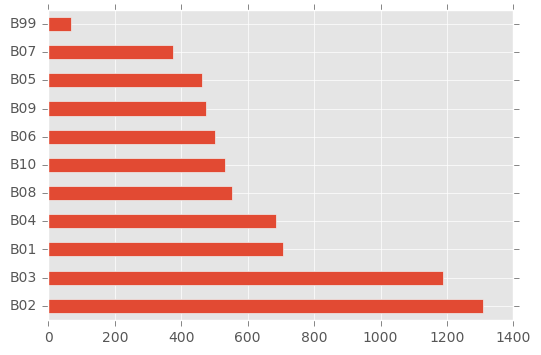

In [143]:
#with pd.option_context('display.max_rows', 999):
#    print(df['Battalion'].value_counts(dropna = False))
    
df['Battalion'].value_counts(dropna = False).plot(kind='barh')

Battalion B02 has been the busiest in the first week of January in 2017

> ### Plotting the frequency of the type of calls

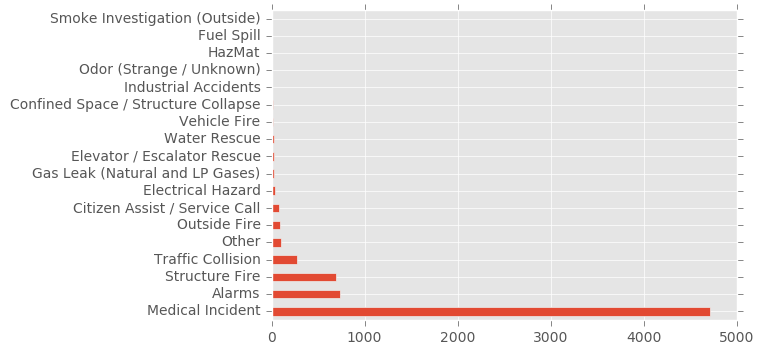

In [140]:
#with pd.option_context('display.max_rows', 999):
#    print(df['Call Type'].value_counts(dropna = False))

df['Call Type'].value_counts(dropna = False).plot(kind='barh')

Medical incidents are the most common type of calls assigned to SFFD followed by Alarms, Structure Fire and Traffic Collision. There have been close to 5000 medical incidents assigned to SFFD in 1 week. 

> ### Plotting the call frequency at various Zip Codes

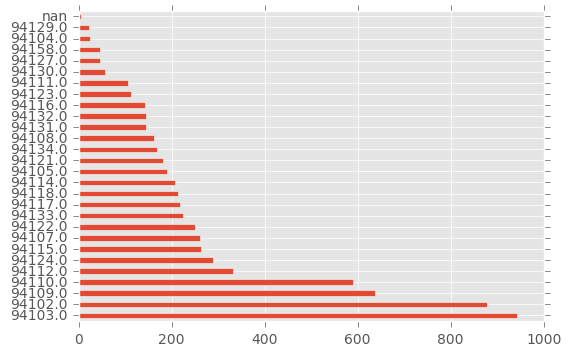

In [139]:
#with pd.option_context('display.max_rows', 999):
#    print(df['Zipcode of Incident'].value_counts(dropna = False))
    
df['Zipcode of Incident'].value_counts(dropna = False).plot(kind='barh')

SFFD gets most calls from Zipcode 94103 followed by 94102, 94109 and 94110

> ### Plotting the call frequency at various Neighborhoods

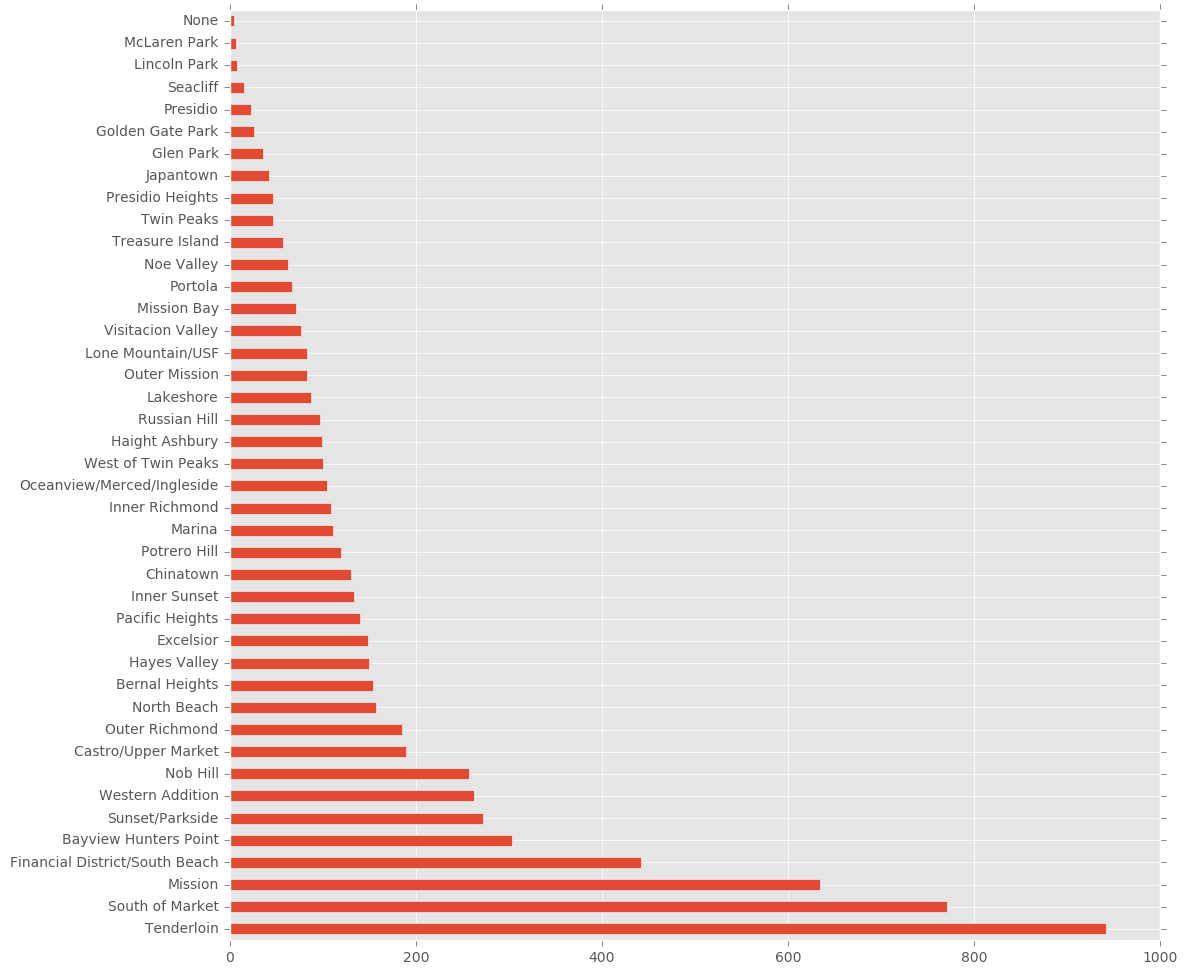

In [149]:
#with pd.option_context('display.max_rows', 999):
#    print(df['Neighborhood  District'].value_counts(dropna = False))
    
df['Neighborhood  District'].value_counts(dropna = False).plot(kind='barh', figsize = (12,12))

The top 5 neighborhoods in the decreasing order of call frequency are Tenderloin, SoMa, Mission, Financial District/ South Beach, Bayview Hunters Point

> ### Correlation Matrix of the dataset

In [109]:
df.corr()

,Call Number,Incident Number,Zipcode of Incident,Station Area,Box,Final Priority,ALS Unit,Number of Alarms,Unit sequence in call dispatch
Call Number,1.000000,0.996139,0.006495,0.010616,0.010093,0.016143,-0.014288,0.026244,0.052443
Incident Number,0.996139,1.000000,0.009726,0.013657,0.012139,0.018930,-0.013202,0.020358,0.055286
Zipcode of Incident,0.006495,0.009726,1.000000,0.308410,0.469502,0.019521,-0.023065,0.101661,0.080497
Station Area,0.010616,0.013657,0.308410,1.000000,0.343474,0.017021,-0.036853,0.007060,0.042520
Box,0.010093,0.012139,0.469502,0.343474,1.000000,-0.001092,0.034697,0.033469,-0.000481
Final Priority,0.016143,0.018930,0.019521,0.017021,-0.001092,1.000000,-0.130903,0.037102,0.222199
ALS Unit,-0.014288,-0.013202,-0.023065,-0.036853,0.034697,-0.130903,1.000000,-0.042675,-0.191182
Number of Alarms,0.026244,0.020358,0.101661,0.007060,0.033469,0.037102,-0.042675,1.000000,0.311101
Unit sequence in call dispatch,0.052443,0.055286,0.080497,0.042520,-0.000481,0.222199,-0.191182,0.311101,1.000000


Zipcode and Box are collinear. San Francisco is divided into 2400+ boxes and assigned to Battalions. Box would give a better measure of calls to SFFD.

> ### Linear Regression Model for features Box and Battaion

In [110]:
# Create a set of dummy variables from the Battalion variable
df_Battalion = pd.get_dummies(df['Battalion'])

In [111]:
df_new = df.join(df_Battalion)

In [119]:
df_new.columns

Index(['Call Number', 'Unit ID', 'Incident Number', 'Call Type', 'Call Date',
       'Watch Date', 'Received DtTm', 'Entry DtTm', 'Dispatch DtTm',
       'Response DtTm', 'On Scene DtTm', 'Transport DtTm', 'Hospital DtTm',
       'Call Final Disposition', 'Available DtTm', 'Address', 'City',
       'Zipcode of Incident', 'Battalion', 'Station Area', 'Box',
       'Original Priority', 'Priority', 'Final Priority', 'ALS Unit',
       'Call Type Group', 'Number of Alarms', 'Unit Type',
       'Unit sequence in call dispatch', 'Fire Prevention District',
       'Supervisor District', 'Neighborhood  District', 'Location', 'RowID',
       'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09', 'B10',
       'B99'],
      dtype='object')

In [126]:
X = df_new[[      
        'B01', 
        'B02', 
        'B03', 
        'B04', 
        'B05', 
        'B06', 
        'B07', 
        'B08', 
        'B09', 
        'B10',
        'B99'
    ]]

y = df_new['Box']
       
model = linear_model.LinearRegression()
model.fit(X,y)

print(model.intercept_)
print(model.coef_)

1.35279409239e+15
[ -1.35279409e+15  -1.35279409e+15  -1.35279409e+15  -1.35279409e+15
  -1.35279409e+15  -1.35279409e+15  -1.35279409e+15  -1.35279409e+15
  -1.35279409e+15  -1.35279409e+15  -1.35279409e+15]


In [128]:
model.score(X, y)

0.75312955963034089

Model score of 75.3%

> ### Hypothesis

Location and time of the day will help in measuring the call traffic on the Battalions of San Francisco Fire Department 

> ### Next Steps

Using time series to measure the effect of time of the day, type of the day (NYE, July 4th fireworks) on calls to SFFD. SFFD day is logged from 8am - 8pm PST. Including data of Jan 31 2016 would provide more insight on call frequency during New Year 2017 celebration.

In [4]:
df['Call Type'].unique()

array(['Elevator / Escalator Rescue', 'Medical Incident', 'Structure Fire',
       'Alarms', 'Gas Leak (Natural and LP Gases)', 'Traffic Collision',
       'Other', 'Citizen Assist / Service Call', 'Outside Fire',
       'Odor (Strange / Unknown)', 'Confined Space / Structure Collapse',
       'Vehicle Fire', 'Smoke Investigation (Outside)',
       'Electrical Hazard', 'Water Rescue', 'Industrial Accidents',
       'HazMat', 'Fuel Spill'], dtype=object)

In [31]:
def find_fire(call_type):
    if call_type == "Structure Fire":
        return 1
    else:
        return 0

for row in df['Call Type']:
    df['structure_fire'] = find_fire(row)

In [29]:
df.drop('structure_fire', axis=1, inplace=True)

In [32]:
df['structure_fire'].value_counts()

0    6852
Name: structure_fire, dtype: int64